In [ ]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
import re
from typing import List, Tuple
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_full = pd.read_csv("/content/drive/My Drive/DS266/Final Project/data/absa_features_target.csv")
df_full.head()

,Ticker,Drug,Indication,Stage,Date,Catalyst,Shares_Millions,Market_Cap,Volatility,Share_Price_D-1,...,has_regulatory,has_financial,has_enrollment,has_clinical,has_catalyst,pos_count,neg_count,neu_count,headline_sentiment,TARGET
0,SNDX,Niktimvo (axatilimab-csfr),Chronic Graft versus host disease (cGvHD)Â,BLA Filing,2024-01-02,"BLA submitteed to the FDA, noted January 2, 2024.",86.0,1853.94083,47.8089,21.61000,...,1,0,0,0,0,1,0,0,1,pos
1,INCY,Niktimvo (axatilimab-csfr),Chronic Graft versus host disease (cGvHD)Â,BLA Filing,2024-01-02,"BLA submitteed to the FDA, noted January 2, 2024.",195.0,14667.94963,26.2121,62.79000,...,1,0,0,0,0,1,0,0,1,pos
2,ATAI,EMP-01,Post-Traumatic Stress Disorder (PTSD)Â,Phase 1,2024-01-02,"Phase 1 was well-tolerated, and treatment-rela...",214.0,280.55770,76.7738,1.41000,...,0,0,0,0,0,2,0,0,1,pos
3,AVXL,ANAVEX 2-73-RS-003 - (EXCELLENCE),Pediatric Rett SyndromeÂ,Phase 2/3,2024-01-02,Phase 2/3 results missed a primary endpoint on...,85.0,496.21296,88.6481,9.31000,...,0,0,0,0,0,0,3,0,-1,neg
4,ATXI,AJ201,Spinal and bulbar muscular atrophy (SBMA)Â,Phase 1/2,2024-01-02,"Phase 1b/2 enrollment completed, noted January...",3.0,2.11961,106.4138,12.07503,...,0,0,1,0,0,2,0,0,1,pos


In [ ]:
# Convert the 'Date' column to datetime objects
df_full['Date'] = pd.to_datetime(df_full['Date'])

# Define the cutoff date
cutoff_date = '2024-10-01'

# Split the data
train_df = df_full[df_full['Date'] < cutoff_date].copy()
test_df = df_full[df_full['Date'] >= cutoff_date].copy()

# Display the shapes of the resulting DataFrames
print(f"Training Set Shape: {train_df.shape}")
print(f"Testing Set Shape: {test_df.shape}")

Training Set Shape: (2087, 37)
Testing Set Shape: (823, 37)


In [ ]:
NORMALIZE_REPLACEMENTS = [
    (r"\bsubmitteed\b", "submitted"),           # typo
    (r"â\xa0read less", ""),                    # scrape artifact
    (r"\s+", " "),                              # collapse whitespace
    (r"\brefusaal\b", "refusal"),               # typo
]

def preprocess_text(s: str) -> str:
    s = s or ""
    for pat, rep in NORMALIZE_REPLACEMENTS:
        s = re.sub(pat, rep, s, flags=re.I)
    return s.strip()

In [ ]:
# ----- Opinion cues → semantic labels for NER (EFF_POS, REG_NEG, etc.) -----
OPINION_LABEL_PATTERNS = [
    # ---------------- EFFICACY (NEG) ----------------
    # miss primary / no difference / futility / discontinued for poor efficacy
    (r"\b(did not meet|failed to meet|missed)\s+(the\s+)?(primary|co-?primary)\s+endpoint(s)?\b", "EFF_NEG"),
    (r"\bnon[- ]?significant\b|\bnot\s+statistically\s+significant\b|\bp\s*>=\s*0\.0?\d+\b", "EFF_NEG"),
    (r"\b(?:no|not)\s+(?:difference|improvement|reduction|increase)\s+(?:vs\.?|versus|over|compared\s+to)\s+(?:placebo|control)\b", "EFF_NEG"),
    (r"\bfutilit(?:y|ies)\b|\bstopped\s+early\s+for\s+futility\b", "EFF_NEG"),
    (r"\b(?:program|study|trial)\s+(?:discontinued|terminated|halted|stopped)\s+(?:due to|because of)\s+(?:limited|insufficient)\s+(?:signs|evidence)\s+of\s+efficacy\b", "EFF_NEG"),

    # ---------------- EFFICACY (POS) ----------------
    # met primary / stat sig / biomarker effect / dose-dependent responses / knockdown
    (r"\b(met|achieved|attained)\s+(the\s+)?(primary|co-?primary)\s+endpoint(s)?\b", "EFF_POS"),
    (r"\b(statistically\s+significant|p\s*<\s*0\.0?\d+|significant\s+improvement)\b", "EFF_POS"),
    (r"\b(?:biomarker[s]?)\s+(?:show(?:ed)?|demonstrat(?:e|ed)|exhibit(?:s|ed))\s+"
     r"(?:greater|significant|higher|lower)\s+(?:increase|reduction|decrease|improvement)\s+"
     r"(?:vs\.?|versus|over|compared\s+to)\s+(?:placebo|control)\b", "EFF_POS"),
    # dose-dependent response / correction / knockdown within a short window
    (r"\bdose[- ]?dependent\b[\s\S]{0,80}\b(?:increase|improvement|correction|knockdown|reduction)\b", "EFF_POS"),
    # quantitative efficacy phrases
    (r"\b(?:mean|median|average)?\s*(?:absolute\s+)?[A-Za-z\- ]*level\s+of\s+\d+(?:\.\d+)?%(\s+of\s+normal)?\b", "EFF_POS"),
    (r"\bchange\s+from\s+baseline(?:\s+at\s+\d+\s+(?:months?|weeks?))?\s*(?:of|:)?\s*[-+]?\d+(?:\.\d+)?%\b", "EFF_POS"),

    # ---------------- SAFETY (POS/NEG) ----------------
    # stronger coverage for "no safety signals of concern"
    (r"\bno\s+(?:safety\s+signals?\s+of\s+concern|safety\s+concerns?)\b", "SAFETY_POS"),
    (r"\b(?:well[- ]tolerated|generally\s+(?:well[- ]tolerated|safe)|favorable\s+(?:safety|tolerability)|manageable\s+(?:safety|toxicit(?:y|ies)))\b", "SAFETY_POS"),
    (r"\bno\s+(?:DLTs?|SAEs?|serious\s+adverse\s+events?)\b", "SAFETY_POS"),
    (r"\b(?:DLTs?|serious\s+adverse\s+events?|safety\s+concern|black\s+box|boxed\s+warning)\b", "SAFETY_NEG"),

    # ---------------- CLINICAL OPS (POS/NEG) ----------------
    (r"\b(dosing|dose)\s+(?:initiated|has\s+begun|began|started|underway)\b", "CLIN_POS"),
    (r"\b(?:first|second|third|initial)\s+cohort\s+(?:completed|complete|finished)\b|\bcohort\s*\d+\s+(?:complete|completed)\b", "CLIN_POS"),
    (r"\b(?:dose[- ]?escalation|dose[- ]?expansion)\s+(?:complete(?:d)?|initiated|started|underway|begun)\b", "CLIN_POS"),
    (r"\b(?:last\s+(?:patient|subject)\s+(?:dosed|treated)|LPD)\b", "CLIN_POS"),
    (r"\bIND[- ]enabling\s+studies?\s+(?:complete|completed|finished|concluded)\b", "CLIN_POS"),
    # MTD reached / dose optimization
    (r"\b(?:maximum[- ]tolerated\s+dose|MTD)\s+(?:has\s+been\s+)?(?:reached|determined|identified)\b", "CLIN_POS"),
    (r"\bdose\s+optimization\b", "CLIN_POS"),
    # dosing paused/hold
    (r"\b(dosing|dose)\s+(?:paused|suspended|halted|stopped|on\s+hold)\b", "CLIN_NEG"),

    # ---------------- ENROLLMENT (POS/NEG) ----------------
    (r"\benrollment\s+(?:complete(?:d)?|closed|finish(?:ed)?|has\s+(?:been\s+)?completed|was\s+completed|has\s+finished|completion)\b|\bfully\s+enrolled\b", "ENROLL_POS"),
    (r"\b(?:first|last)\s+(?:patient|subject)\s+(?:in|enrolled|out|visit)\b|\b(?:FPI|LSI|LPI|LPO|LPD|LSO)\b", "ENROLL_POS"),
    (r"\benrollment\s+(?:paused|suspended|halted|slowed|delayed|terminated|stopped)\b|\benrollment\s+challenges\b|\bslow\s+enrollment\b", "ENROLL_NEG"),

    # ---------------- REGULATORY (POS/NEG) ----------------
    (r"\b(?:FDA)\s+(?:approval|approved)\b", "REG_POS"),
    (r"\b(?:Study\s+May\s+Proceed|May\s+Proceed\s+letter)\b", "REG_POS"),
    (r"\b(?:BLA|NDA|MAA)\s+(?:submi(?:t|tt)ed|submission|filed|filing|resubmitted|accepted|acceptance|validated|approved)\b", "REG_POS"),
    (r"\b(?:priority\s+review|breakthrough\s+therapy|fast[- ]track|orphan\s+designation)\b", "REG_POS"),
    (r"\b(?:FDA|EMA)\s+(?:acceptance|acknowledg(?:e|ment)\s+letter|granted|approved|cleared)\b", "REG_POS"),
    (r"\b(?:CRL|complete\s+response\s+letter|refusal\s+to\s+file|RTF|clinical\s+hold|partial\s+clinical\s+hold|withdrawn|withdrawal|terminated|suspended|deficiency\s+letter)\b", "REG_NEG"),
]

OPN_RE = [(re.compile(p, re.I), label) for p, label in OPINION_LABEL_PATTERNS]


In [ ]:
Span = Tuple[int, int, str]  # (start_char, end_char, label)

def find_opinion_spans(text: str) -> List[Span]:
    text = preprocess_text(text or "")
    spans: List[Span] = []
    for pattern, label in OPN_RE:
        for m in pattern.finditer(text):
            spans.append((m.start(), m.end(), label))
    return spans

In [ ]:
def spans_to_bio_tokens(text: str, spans: List[Span]):
    text = preprocess_text(text or "")
    tokens = text.split()
    labels = ["O"] * len(tokens)

    # map span ranges to label
    for s, e, lab in spans:
        # naive word-level alignment: loop tokens & mark those fully inside [s,e)
        offset = 0
        for i, tok in enumerate(tokens):
            start = text.find(tok, offset)
            end = start + len(tok)
            offset = end

            if start >= s and end <= e:
                if labels[i] == "O":
                    labels[i] = f"B-{lab}" if not any(l.endswith(lab) for l in labels[:i]) else f"I-{lab}"

    return tokens, labels

In [ ]:
def auto_tag_spans_for_text(raw_text: str) -> str:
    """
    Given a raw Catalyst string, returns a JSON-encoded list of spans:
    [{"start": s, "end": e, "label": ner_label}, ...]
    """
    if raw_text is None:
        raw_text = ""
    text = preprocess_text(str(raw_text))

    opinion_spans = find_opinion_spans(text)

    span_dicts = [
        {"start": int(s), "end": int(e), "label": lbl}
        for (s, e, lbl) in opinion_spans
    ]
    return json.dumps(span_dicts, ensure_ascii=False)


In [ ]:
df_full["auto_spans"] = df_full["Catalyst"].apply(auto_tag_spans_for_text)

# Optional: save for annotation / NER training
df_full.to_csv("/content/drive/My Drive/DS266/Final Project/data/absa_features_with_spans.csv", index=False)


In [ ]:
df_full

,Ticker,Drug,Indication,Stage,Date,Catalyst,Shares_Millions,Market_Cap,Volatility,Share_Price_D-1,...,has_financial,has_enrollment,has_clinical,has_catalyst,pos_count,neg_count,neu_count,headline_sentiment,TARGET,auto_spans
0,SNDX,Niktimvo (axatilimab-csfr),Chronic Graft versus host disease (cGvHD)Â,BLA Filing,2024-01-02,"BLA submitteed to the FDA, noted January 2, 2024.",86.0,1853.94083,47.8089,21.61000,...,0,0,0,0,1,0,0,1,pos,"[{""start"": 0, ""end"": 13, ""label"": ""REG_POS""}]"
1,INCY,Niktimvo (axatilimab-csfr),Chronic Graft versus host disease (cGvHD)Â,BLA Filing,2024-01-02,"BLA submitteed to the FDA, noted January 2, 2024.",195.0,14667.94963,26.2121,62.79000,...,0,0,0,0,1,0,0,1,pos,"[{""start"": 0, ""end"": 13, ""label"": ""REG_POS""}]"
2,ATAI,EMP-01,Post-Traumatic Stress Disorder (PTSD)Â,Phase 1,2024-01-02,"Phase 1 was well-tolerated, and treatment-rela...",214.0,280.55770,76.7738,1.41000,...,0,0,0,0,2,0,0,1,pos,"[{""start"": 12, ""end"": 26, ""label"": ""SAFETY_POS""}]"
3,AVXL,ANAVEX 2-73-RS-003 - (EXCELLENCE),Pediatric Rett SyndromeÂ,Phase 2/3,2024-01-02,Phase 2/3 results missed a primary endpoint on...,85.0,496.21296,88.6481,9.31000,...,0,0,0,0,0,3,0,-1,neg,[]
4,ATXI,AJ201,Spinal and bulbar muscular atrophy (SBMA)Â,Phase 1/2,2024-01-02,"Phase 1b/2 enrollment completed, noted January...",3.0,2.11961,106.4138,12.07503,...,0,1,0,0,2,0,0,1,pos,"[{""start"": 11, ""end"": 31, ""label"": ""ENROLL_POS""}]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,KROS,Cibotercept (KER-012) - (TROPOS),Pulmonary arterial hypertension (PAH) and diso...,Phase 2,2025-01-05,Phase 2 trial voluntarily halted all dosing du...,40.0,652.16929,191.7289,16.10000,...,0,0,0,0,0,0,0,0,neg,[]
2906,OCS,OCS-05 - (ACUITY),Acute optic neuritisÂ,Phase 2,2025-01-06,"Phase 2 trial met primary safety endpoint, not...",43.0,740.32890,42.3619,17.56000,...,0,0,0,0,2,0,0,1,pos,[]
2907,IMAB,Uliledlimab (TJ004309),Solid tumorsÂ,Phase 1,2025-01-06,"Development of uliledlimab is being paused, no...",81.0,87.94945,75.5089,0.93990,...,0,0,0,0,0,0,0,0,pos,[]
2908,VYNE,Repibresib Gel (VYN201),VitiligoÂ,Phase 2b,2025-01-06,"Phase 2b enrollment completed, noted January 6...",25.0,59.00573,70.7955,3.46000,...,0,1,0,0,2,0,0,1,neg,"[{""start"": 9, ""end"": 29, ""label"": ""ENROLL_POS""}]"


In [ ]:
empty_autospans_index = df_full[df_full['auto_spans'].apply(lambda x: len(json.loads(x)) == 0)].index

<Axes: title={'center': 'Distribution of Stage for Empty Auto Spans'}, xlabel='Stage'>

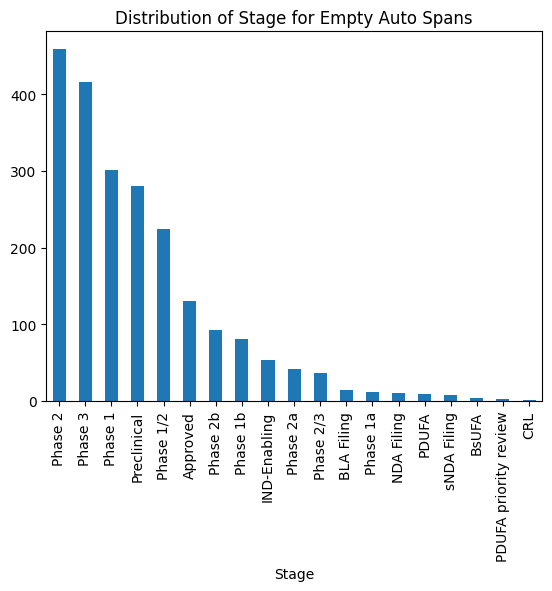

In [ ]:
df_full.iloc[empty_autospans_index]['Stage'].value_counts().plot(kind='bar', title='Distribution of Stage for Empty Auto Spans')

In [ ]:
stages_with_empty_spans = df_full.loc[empty_autospans_index, 'Stage']
print(stages_with_empty_spans.head())

3     Phase 2/3
8       Phase 3
9       Phase 3
10      Phase 3
16    Phase 1/2
Name: Stage, dtype: object


In [ ]:
stage_indices_first_20 = {}
unique_stages = stages_with_empty_spans.unique()

for stage in unique_stages:
    # Get the indices from empty_autospans_index that correspond to the current stage
    # The index of stages_with_empty_spans corresponds to the original df_full index
    indices_for_stage = stages_with_empty_spans[stages_with_empty_spans == stage].index.tolist()
    # Store the first 20 original DataFrame indices for this stage
    stage_indices_first_20[stage] = indices_for_stage[:20]

print("Keys (Stages) in stage_indices_first_20:", stage_indices_first_20.keys())
print("First 20 indices for 'Phase 3':", stage_indices_first_20.get('Phase 3'))


Keys (Stages) in stage_indices_first_20: dict_keys(['Phase 2/3', 'Phase 3', 'Phase 1/2', 'Preclinical', 'Phase 1', 'Phase 2', 'Phase 2a', 'IND-Enabling', 'Phase 2b', 'Phase 1b', 'BLA Filing', 'Approved', 'BsUFA', 'NDA Filing', 'PDUFA', 'sNDA Filing', 'PDUFA priority review', 'CRL', 'Phase 1a'])
First 20 indices for 'Phase 3': [8, 9, 10, 52, 57, 64, 87, 107, 108, 109, 115, 124, 131, 136, 143, 144, 145, 146, 156, 161]


In [ ]:
indices_for_gpt_prompt = []
for stage, indices in stage_indices_first_20.items():
    indices_for_gpt_prompt.extend(indices)

print(f"Total number of indices: {len(indices_for_gpt_prompt)}")
print(f"First 20 indices: {indices_for_gpt_prompt[:20]}")

Total number of indices: 281
First 20 indices: [3, 210, 239, 352, 359, 531, 532, 577, 685, 739, 786, 815, 864, 900, 927, 941, 1103, 1160, 1292, 1374]


Add in GPT Prompting

In [ ]:
# one schema, one job: return spans as JSON
LABELS_LITERAL = "EFF_POS, EFF_NEG, SAFETY_POS, SAFETY_NEG, CLIN_POS, CLIN_NEG, REG_POS, REG_NEG, ENROLL_POS, ENROLL_NEG, CONF_POS"

gpt_span_prompt = """Extract spans in the text that express clinical EFFICACY, SAFETY, REGULATORY,
ENROLLMENT, or CLINICAL-OPS signals. Return a JSON list of objects with fields:
label ∈ {{EFF_POS, EFF_NEG, SAFETY_POS, SAFETY_NEG, CLIN_POS, CLIN_NEG, REG_POS, REG_NEG, ENROLL_POS, ENROLL_NEG, CONF_POS}}
start: integer (char index, inclusive), end: integer (char index, exclusive).

Rules:
- Tag the minimal meaningful phrase (e.g., "met the primary endpoint", "clinical hold",
  "no safety signals of concern", "dose-dependent splicing correction", "MTD has been reached").
- Use exact character indices relative to the provided TEXT (do not trim or normalize).
- Return [] if nothing relevant.

TEXT:
<<<{text}>>>
"""

In [ ]:
import json, time
from typing import List, Dict, Any
import openai

# Your working client + model
# from openai import OpenAI
client = openai.OpenAI()

def call_gpt_for_spans(text: str) -> list:
    txt = "" if text is None else str(text)
    msg = gpt_span_prompt.format(text=txt, labels=LABELS_LITERAL)
    resp = client.chat.completions.create(
        model="gpt-4.1",
        messages=[{"role": "user", "content": msg}]
    )
    content = resp.choices[0].message.content.strip()
    try:
        spans = json.loads(content)
        return [
            {"start": int(d["start"]), "end": int(d["end"]), "label": d["label"], }
            for d in spans if {"start","end","label"} <= d.keys()
        ]
    except Exception:
        return []

In [ ]:
for index in indices_for_gpt_prompt:
  text = df_full.loc[index, "Catalyst"]
  print(text)
  new_span = call_gpt_for_spans(text)
  print(new_span)
  # Convert the Python list to a JSON string before assigning
  df_full.loc[index, "auto_spans"] = json.dumps(new_span, ensure_ascii=False)
  time.sleep(0.1)

Phase 2/3 results missed a primary endpoint on the LS Mean difference (SE) points between treated and placebo, noted January 2, 2024.
[{'start': 12, 'end': 55, 'label': 'EFF_NEG'}]
Phase 2/3 enrollment voluntary pause enables time to evaluate study data further and for the independent DSMB to conduct an unblinded assessment and recommend next steps, which could include changes t
[{'start': 6, 'end': 44, 'label': 'ENROLL_NEG'}]
Phase 2/3 last patient completed, noted February 14, 2024.
[{'start': 7, 'end': 45, 'label': 'ENROLL_POS'}]
Phase 2/3 90mg data reported a 50% overall response rate, including one complete response and two partial responses, and a 100% disease control rate overall, noted March 5, 2024.
[{'start': 21, 'end': 55, 'label': 'EFF_POS'}, {'start': 89, 'end': 117, 'label': 'EFF_POS'}]
Phase 2/3 data reported that all three treatment groups had robust virologic suppression at six months, with consistently low viral loads throughout the study, noted March 5, 2024.
[{'star

In [ ]:
df_full

,Ticker,Drug,Indication,Stage,Date,Catalyst,Shares_Millions,Market_Cap,Volatility,Share_Price_D-1,...,has_financial,has_enrollment,has_clinical,has_catalyst,pos_count,neg_count,neu_count,headline_sentiment,TARGET,auto_spans
0,SNDX,Niktimvo (axatilimab-csfr),Chronic Graft versus host disease (cGvHD)Â,BLA Filing,2024-01-02,"BLA submitteed to the FDA, noted January 2, 2024.",86.0,1853.94083,47.8089,21.61000,...,0,0,0,0,1,0,0,1,pos,"[{""start"": 0, ""end"": 13, ""label"": ""REG_POS""}]"
1,INCY,Niktimvo (axatilimab-csfr),Chronic Graft versus host disease (cGvHD)Â,BLA Filing,2024-01-02,"BLA submitteed to the FDA, noted January 2, 2024.",195.0,14667.94963,26.2121,62.79000,...,0,0,0,0,1,0,0,1,pos,"[{""start"": 0, ""end"": 13, ""label"": ""REG_POS""}]"
2,ATAI,EMP-01,Post-Traumatic Stress Disorder (PTSD)Â,Phase 1,2024-01-02,"Phase 1 was well-tolerated, and treatment-rela...",214.0,280.55770,76.7738,1.41000,...,0,0,0,0,2,0,0,1,pos,"[{""start"": 12, ""end"": 26, ""label"": ""SAFETY_POS""}]"
3,AVXL,ANAVEX 2-73-RS-003 - (EXCELLENCE),Pediatric Rett SyndromeÂ,Phase 2/3,2024-01-02,Phase 2/3 results missed a primary endpoint on...,85.0,496.21296,88.6481,9.31000,...,0,0,0,0,0,3,0,-1,neg,"[{""start"": 12, ""end"": 55, ""label"": ""EFF_NEG""}]"
4,ATXI,AJ201,Spinal and bulbar muscular atrophy (SBMA)Â,Phase 1/2,2024-01-02,"Phase 1b/2 enrollment completed, noted January...",3.0,2.11961,106.4138,12.07503,...,0,1,0,0,2,0,0,1,pos,"[{""start"": 11, ""end"": 31, ""label"": ""ENROLL_POS""}]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,KROS,Cibotercept (KER-012) - (TROPOS),Pulmonary arterial hypertension (PAH) and diso...,Phase 2,2025-01-05,Phase 2 trial voluntarily halted all dosing du...,40.0,652.16929,191.7289,16.10000,...,0,0,0,0,0,0,0,0,neg,[]
2906,OCS,OCS-05 - (ACUITY),Acute optic neuritisÂ,Phase 2,2025-01-06,"Phase 2 trial met primary safety endpoint, not...",43.0,740.32890,42.3619,17.56000,...,0,0,0,0,2,0,0,1,pos,[]
2907,IMAB,Uliledlimab (TJ004309),Solid tumorsÂ,Phase 1,2025-01-06,"Development of uliledlimab is being paused, no...",81.0,87.94945,75.5089,0.93990,...,0,0,0,0,0,0,0,0,pos,[]
2908,VYNE,Repibresib Gel (VYN201),VitiligoÂ,Phase 2b,2025-01-06,"Phase 2b enrollment completed, noted January 6...",25.0,59.00573,70.7955,3.46000,...,0,1,0,0,2,0,0,1,neg,"[{""start"": 9, ""end"": 29, ""label"": ""ENROLL_POS""}]"


In [ ]:
df_full.to_csv("/content/drive/My Drive/DS266/Final Project/data/absa_features_with_spans_withgpt.csv", index=False)

Check what is still empty

In [ ]:
empty_autospans_index = df_full[df_full['auto_spans'].apply(lambda x: len(json.loads(x)) == 0)].index
empty_autospans_index  = [i for i in empty_autospans_index if i not in indices_for_gpt_prompt]

In [ ]:
print(f"There are currently {len(empty_autospans_index)} missing.")

There are currently 1899 missing.


In [ ]:
# take a portion of empty_autospans_index
empty_autospans_index_p1 = empty_autospans_index[:400]

In [ ]:
for index in empty_autospans_index_p1:
  text = df_full.loc[index, "Catalyst"]
  print(text)
  new_span = call_gpt_for_spans(text)
  print(new_span)
  # Convert the Python list to a JSON string before assigning
  df_full.loc[index, "auto_spans"] = json.dumps(new_span, ensure_ascii=False)
  time.sleep(0.1)

Phase 3 reported that KCCQ-CSS estimated treatment difference between semaglutide 2.4 mg and placebo of 7.8, noted January 31, 2024.
[{'start': 22, 'end': 94, 'label': 'EFF_POS'}]
Phase 3 enrolment completed, noted February 1, 2024.
[{'start': 6, 'end': 32, 'label': 'ENROLL_POS'}]
Additional Phase 3 data reported improved functions and quality of life at 30 months, noted February 2, 2024.
[{'start': 24, 'end': 42, 'label': 'EFF_POS'}]
Additional Phase 3 data reported improved functions and quality of life at 30 months, noted February 2, 2024.
[{'start': 28, 'end': 54, 'label': 'EFF_POS'}]
Phase 2 initial data presented at ORS reported that Visual Analog Scale, Oswestry Disability Index, Roland Morris Disability Questionnaire, and Functional Rating Index collected at weeks 26 and 52 pos
[{'start': 12, 'end': 31, 'label': 'CLIN_POS'}]
Phase 2 subgroup analysis reported numerical superiority in change in BCVA along with strong anatomic control compared to the aflibercept control group, no

In [ ]:
df_full.to_csv("/content/drive/My Drive/DS266/Final Project/data/absa_features_with_spans_withgpt.csv", index=False)

New chunk

In [ ]:
empty_autospans_index_1 = df_full[df_full['auto_spans'].apply(lambda x: len(json.loads(x)) == 0)].index
empty_autospans_index_1  = [i for i in empty_autospans_index_1 if i not in empty_autospans_index_p1]

In [ ]:
print(f"There are currently {len(empty_autospans_index_1)} missing.")

There are currently 1540 missing.


In [ ]:
empty_autospans_index_p2 = empty_autospans_index_1[:750]

In [ ]:
for index in empty_autospans_index_p2:
  text = df_full.loc[index, "Catalyst"]
  print(text)
  new_span = call_gpt_for_spans(text)
  print(new_span)
  # Convert the Python list to a JSON string before assigning
  df_full.loc[index, "auto_spans"] = json.dumps(new_span, ensure_ascii=False)
  time.sleep(0.1)

Preclinical development to commence in early 2024, with IND submission planned in 2024, noted January 3, 2024.
[]
Phase 1 expanded to include patients with atopic dermatitis, noted Janaury 4, 2024.
[]
Phase 3a trial completed, noted January 8, 2024
[]
Phase 1 trial initiated, noted January 8, 2024.
[]
Phase 2 was initiated, noted January 8, 2024.
[]
Approved January 16, 2024.
[]
Approved January 16, 2024.
[]
Approved January 16, 2024.
[]
Phase 2a trial initiated, noted January 17, 2024.
[]
Pre-clinical results demonstrated that once daily oral administration in rats, of sitagliptin alone (180 mg/kg/day), DA-1241 alone (100 mg/kg/day), or sitagliptin in combination with DA-1241 (up to 18
[]
Preclinical data supports the potential of SRK-439 to preserve lean muscle mass as part of healthy weight loss, noted January 25, 2024.
[]
Approved January 25, 2024.
[]
Approved January 25, 2024.
[]
Phase 1b/2 dosing was initiated, noted January 29, 2024.
[]
Phase 1 dosing of first patient completed,

In [ ]:
df_full.to_csv("/content/drive/My Drive/DS266/Final Project/data/absa_features_with_spans_withgpt.csv", index=False)

New Chunk

In [ ]:
empty_autospans_index_2 = df_full[df_full['auto_spans'].apply(lambda x: len(json.loads(x)) == 0)].index
empty_autospans_index_2  = [i for i in empty_autospans_index_2 if i not in empty_autospans_index_p2]

In [ ]:
print(f"There are currently {len(empty_autospans_index_2)} missing.")

There are currently 847 missing.


In [ ]:
for index in empty_autospans_index_2:
  text = df_full.loc[index, "Catalyst"]
  print(text)
  new_span = call_gpt_for_spans(text)
  print(new_span)
  # Convert the Python list to a JSON string before assigning
  df_full.loc[index, "auto_spans"] = json.dumps(new_span, ensure_ascii=False)
  time.sleep(0.1)

Phase 2 was initiated, noted on February 13, 2024.
[]
Phase 1b/2 dosing commenced on February 14, 2024.
[]
Phase 2 trial initiated, noted February 14, 2024.
[]
Phase 1 was discontinued due to resource allocation, noted February 15, 2024.
[]
Phase 1 dosing commenced, noted February 20, 2024.
[{'start': 0, 'end': 26, 'label': 'CLIN_POS'}]
Phase 2 trial initiated, noted February 28, 2024.
[]
Preclinical data presented at AD/PD reported that GT-02287, through its interaction with glucocerebrosidase (GCase) in the endoplasmic reticulum (ER), aids correct GCase folding, preventing ER retention, ER stress, and ER-associated degradation of mutated GCase enzyme, noted March 5, 2024.Â read less
[]
Preclinical data reported that data demonstrated the ability of RZ358 to similarly blunt both IGF-2 and insulin-mediated insulin-receptor signaling, at levels of these ligands that are disease-relevant in humans, noted March 6, 2024.Â read less
[{'start': 49, 'end': 106, 'label': 'EFF_POS'}]
Preclinica

In [ ]:
df_full.to_csv("/content/drive/My Drive/DS266/Final Project/data/absa_features_with_spans_withgpt.csv", index=False)